# Data Preparing

In [1]:
!pip list | grep "torch"

torch                         1.9.0+cu102
torchsummary                  1.5.1
torchtext                     0.10.0
torchvision                   0.10.0+cu102


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mugan1","key":"1e7737f2708c99e5cec5976bb162f6fb"}'}

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c korean-hate-speech-detection

  0% 0.00/2.11M [00:00<?, ?B/s]
100% 2.11M/2.11M [00:00<00:00, 148MB/s]
  0% 0.00/93.9k [00:00<?, ?B/s]
100% 93.9k/93.9k [00:00<00:00, 86.4MB/s]
  0% 0.00/804k [00:00<?, ?B/s]
100% 804k/804k [00:00<00:00, 112MB/s]
  0% 0.00/725k [00:00<?, ?B/s]
100% 725k/725k [00:00<00:00, 102MB/s]
  0% 0.00/43.1k [00:00<?, ?B/s]
100% 43.1k/43.1k [00:00<00:00, 44.8MB/s]
  0% 0.00/48.4k [00:00<?, ?B/s]
100% 48.4k/48.4k [00:00<00:00, 47.4MB/s]
 89% 81.0M/91.0M [00:00<00:00, 93.9MB/s]
100% 91.0M/91.0M [00:00<00:00, 104MB/s] 
  0% 0.00/89.0k [00:00<?, ?B/s]
100% 89.0k/89.0k [00:00<00:00, 81.2MB/s]


In [ ]:
# install 

!pip install konlpy
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

     |████████████████████████████████| 19.4 MB 230 kB/s 
     |████████████████████████████████| 448 kB 74.4 MB/s 
     |████████████████████████████████| 86 kB 7.3 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 91 (delta 43), reused 22 (delta 6), pack-reused 0
Unpacking objects: 100% (91/91), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2021-08-25 09:51:15--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00

In [ ]:
!pip install transformers==4.4.1
!pip install tokenizers==0.10.1

     |████████████████████████████████| 2.1 MB 5.4 MB/s 
     |████████████████████████████████| 3.3 MB 52.2 MB/s 
     |████████████████████████████████| 895 kB 59.4 MB/s 
     |████████████████████████████████| 3.2 MB 5.3 MB/s 
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.10.3
    Uninstalling tokenizers-0.10.3:
      Successfully uninstalled tokenizers-0.10.3


In [ ]:
# import 

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from konlpy.tag import Mecab
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.svm import SVC
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import re
import os
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizerFast
import collections
import torch
from torch.utils.data import (TensorDataset, DataLoader, RandomSampler, SequentialSampler)
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import time
import torch.optim as optim
import shutil
from glob import glob
from gensim.scripts.glove2word2vec import glove2word2vec
from scipy import spatial
from gensim.models import KeyedVectors, Word2Vec, FastText
mecab = Mecab()
from sklearn.metrics import f1_score

In [ ]:
%cd ..

/content


In [ ]:
df_train = pd.read_csv('train.hate.csv')
df_valid = pd.read_csv('dev.hate.csv')
df_test = pd.read_csv('test.hate.no_label.csv')

In [ ]:
df_train.head()

,comments,label
0,(현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...,hate
1,....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을...,none
2,"...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...",hate
3,"1,2화 어설펐는데 3,4화 지나서부터는 갈수록 너무 재밌던데",none
4,1. 사람 얼굴 손톱으로 긁은것은 인격살해이고2. 동영상이 몰카냐? 메걸리안들 생각...,hate


In [ ]:
# 데이터 전처리 

# labeling 
df_train['label'] = df_train['label'].map({'none':0,'offensive':1, 'hate': 2})
df_valid['label'] = df_valid['label'].map({'none':0,'offensive':1, 'hate': 2})

# preprocessing 
def pre_processing(input_sentence):
    #input_sentence = input_sentence.lower() # 소문자화
    input_sentence = re.sub('<[^>]*>', repl= ' ', string = input_sentence) # "<br />" 처리
    input_sentence = re.sub('[!"$%&\()*+,-./:;<=>?@[\\]^_`{|}~]', repl= ' ', string = input_sentence) # 특수문자 처리 ("'" 제외)
    input_sentence = re.sub('\s+', repl= ' ', string = input_sentence) # 연속된 띄어쓰기 처리
    if input_sentence:
        return input_sentence

df_train['comments'] = df_train['comments'].apply(pre_processing)
df_valid['comments'] = df_valid['comments'].apply(pre_processing)
df_test['comments'] = df_test['comments'].apply(pre_processing)

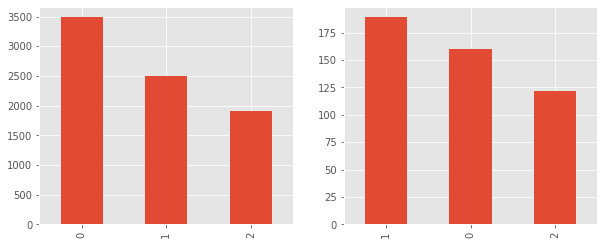

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,4))

df_train.label.value_counts().plot(kind="bar", ax=ax[0])
df_valid.label.value_counts().plot(kind="bar", ax=ax[1]);

# ML and Frequency Based Method

In [ ]:
count_vec = CountVectorizer(tokenizer=mecab.morphs)
x_train = count_vec.fit_transform(df_train['comments'])
x_val = count_vec.transform(df_valid['comments'])
print(count_vec.get_feature_names())
print(x_train.shape)
print(x_val.shape)

['#', "'", "''", '0', '0000000003', '07', '1', '10', '100', '1000', '10000', '11', '11207994540', '12', '120', '13', '130', '14', '140', '1400', '15', '155', '16', '162', '163', '166', '17', '170', '18', '180', '182', '185', '19', '190', '1959', '2', '20', '200', '2000', '2001', '2002', '2006', '2010', '2014', '2016', '2018', '2019', '2020', '206000', '21', '210', '22', '23', '24', '25', '26', '27', '29', '290', '2900', '3', '30', '300', '3000', '3040', '31', '32', '33', '34', '34700', '35', '3500', '36', '37', '38', '39', '4', '40', '41', '43', '45', '468', '47', '48', '5', '50', '500', '503', '52', '53', '54', '540', '55', '57', '59', '6', '60', '61', '625', '65', '66', '677', '68', '69', '7', '70', '72', '75', '77', '78', '79', '79180', '8', '80', '81', '82', '84', '85', '9', '90', '9000', '91', '92', '95', '99', '9900', 'a', 'ab', 'addicted', 'afreecatv', 'again', 'always', 'antijms', 'anything', 'aoa', 'apt', 'atp', 'av', 'b', 'be', 'bj', 'blog', 'bo', 'brother', 'bts', 'btw', 'by

In [ ]:
text_clf = Pipeline([('count_vec', CountVectorizer(tokenizer=mecab.morphs)),
                     ('tfidf', TfidfTransformer()),
                    ('clf', MultinomialNB())])

text_clf = text_clf.fit(df_train['comments'], df_train['label'])

In [ ]:
predicted = text_clf.predict(df_valid.comments)
print(classification_report(predicted, df_valid.label))

              precision    recall  f1-score   support

           0       0.97      0.46      0.63       338
           1       0.26      0.50      0.35       100
           2       0.20      0.76      0.32        33

    accuracy                           0.49       471
   macro avg       0.48      0.57      0.43       471
weighted avg       0.77      0.49      0.55       471



In [ ]:
text_clf_svm = Pipeline([('count_vec', CountVectorizer(tokenizer=mecab.morphs)),
                     ('tfidf', TfidfTransformer()),
                     ('clf-svm', SVC(C=1.0, kernel='rbf', gamma=0.5)),
])
_ = text_clf_svm.fit(df_train['comments'], df_train['label'])
predicted_svm = text_clf_svm.predict(df_valid.comments)
print(classification_report(predicted_svm, df_valid.label))

              precision    recall  f1-score   support

           0       0.93      0.54      0.68       274
           1       0.39      0.56      0.46       132
           2       0.38      0.71      0.49        65

    accuracy                           0.57       471
   macro avg       0.56      0.60      0.55       471
weighted avg       0.70      0.57      0.59       471



In [ ]:
for i in [1, 100, 200, 300, 400, 500, 600, 700, 800, 900] :
  print(df_test['comments'][i])
  print(text_clf_svm.predict(df_test['comments'])[i])

둘다 넘 좋다 행복하세요
0
난 이상엽이 더 멋있어ㅠㅠㅠㅠㅠㅠ
0
저 친구는 누구 딸이길래 그 못난 얼굴로 영화에 주연급 아역으로 갑자기 발탁됐을까 최순실의 정유라 케이스로 의심이 안갈수가 
1
왕실에서 왕자 없다고 타성바지 입양한단 소리만큼 황당 재벌이 정자기증으로 임신 시도란다 너무 웃겨서 충격적이다 ㅋㅋㅋㅋㅋ
1
농구팬이라면 하승진 정말 착하고 예의버른거다알지
0
연좌제도 아니구 죄지은 사람만 욕하자
0
스카이캐슬 보는데 아역들도 먼가 연기가 병풍이 아닌 인상적인 연기를 펼치더라 그중에서 얘가 눈에 들어오더만
0
김나영은 죄지어서 사과문내고 회견했냐 나라가 들썩거릴정도의 덩어리가 훨씬 큰 사건이다 나는 관계없고 잘못없다는 태도 자체가 문제다 가족이다 가족 부창부수라더니 
0
나이트밤무대같은 의상입고 사람들앞에서 춤추는 아내가 뭐가 그리 자랑스러울까ㅠ
0
나영석은 왜 강호동만 키워주나 왜 유느님은 철저하게 배제 시키나 이제 무도도 폐지되어서 김태호pd 눈치 볼필요도 없잖아 자존심은 버려라 
0


# Tokenization

In [ ]:
temp = pd.concat([df_train,df_valid],axis=0)

In [ ]:
with open('df.txt', 'w') as outfile :
  for sentence in temp['comments'] :
    outfile.write(sentence+'\n')

In [ ]:
txt_list = glob('./drive/My Drive/torch_project/train_text/*.txt')
txt_list=txt_list[1:]

In [ ]:
txt_list = glob('./drive/My Drive/torch_project/train_text/*.txt')
txt_list=txt_list[1:]
with open('merge.txt', 'w') as outfile:
    for filename in txt_list:
        with open(filename) as file:
            for line in file:
                outfile.write(line)

In [ ]:
with open('merge.txt', 'r', encoding='utf-8') as f:
    data = f.read().split('\n')

for_generation = False # or normal

if for_generation:
    # 1: '어릴때' -> '어릴, ##때' for generation model
    total_morph=[]
    for sentence in data:
        # 문장단위 mecab 적용
        sentence = re.sub('[A-Za-z]', '', sentence)
        sentence = pre_processing(sentence)
        morph_sentence= []
        count = 0
        for token_mecab in mecab.morphs(sentence):
            token_mecab_save = token_mecab
            if count > 0:
                token_mecab_save = "##" + token_mecab_save  # 앞에 ##를 부친다
                morph_sentence.append(token_mecab_save)
            else:
                morph_sentence.append(token_mecab_save)
                count += 1
        # 문장단위 저장
        total_morph.append(morph_sentence)

else:
    # 2: '어릴때' -> '어릴, 때'   for normal case
    total_morph=[]
    for sentence in data:
        sentence = re.sub('[A-Za-z]', '', sentence)
        #sentence = pre_processing(sentence)
        # 문장단위 mecab 적용
        morph_sentence= mecab.morphs(sentence)
        # 문장단위 저장
        total_morph.append(morph_sentence)
                        
print(total_morph[:3])
print(len(total_morph))

# mecab 적용한 데이터 저장
# ex) 1 line: '어릴 때 보 고 지금 다시 봐도 재밌 어요 ㅋㅋ'
with open('after_mecab.txt', 'w', encoding='utf-8') as f:
    for line in total_morph:
        f.write(' '.join(line)+'\n')

[['현재', '호텔', '주인', '심정', '아', '18', '난', '마른', '하늘', '에', '날벼락', '맞', '고', '호텔', '망하', '게', '생겼', '는데', '누군', '계속', '추모', '받', '네'], ['한국', '적', '인', '미인', '의', '대표', '적', '인', '분', '너무나', '곱', '고', '아름다운', '모습', '그', '모습', '뒤', '의', '슬픔', '을', '미처', '알', '지', '못했', '네요', 'ㅠ'], ['못', '된', '넘', '들', '남', '의', '고통', '을', '즐겼', '던', '넘', '들', '이젠', '마땅', '한', '처벌', '을', '받', '아야지', '그래야', '공정', '한', '사회', '지', '심', '은', '대로', '거두', '거라']]
85314


In [ ]:
# special tokens 

user_defined_symbols = ['[BOS]','[EOS]','[UNK0]','[UNK1]','[UNK2]','[UNK3]','[UNK4]','[UNK5]','[UNK6]','[UNK7]','[UNK8]','[UNK9]']
unused_token_num = 200
unused_list = ['[unused{}]'.format(n) for n in range(unused_token_num)]
user_defined_symbols = user_defined_symbols + unused_list

print(user_defined_symbols)

['[BOS]', '[EOS]', '[UNK0]', '[UNK1]', '[UNK2]', '[UNK3]', '[UNK4]', '[UNK5]', '[UNK6]', '[UNK7]', '[UNK8]', '[UNK9]', '[unused0]', '[unused1]', '[unused2]', '[unused3]', '[unused4]', '[unused5]', '[unused6]', '[unused7]', '[unused8]', '[unused9]', '[unused10]', '[unused11]', '[unused12]', '[unused13]', '[unused14]', '[unused15]', '[unused16]', '[unused17]', '[unused18]', '[unused19]', '[unused20]', '[unused21]', '[unused22]', '[unused23]', '[unused24]', '[unused25]', '[unused26]', '[unused27]', '[unused28]', '[unused29]', '[unused30]', '[unused31]', '[unused32]', '[unused33]', '[unused34]', '[unused35]', '[unused36]', '[unused37]', '[unused38]', '[unused39]', '[unused40]', '[unused41]', '[unused42]', '[unused43]', '[unused44]', '[unused45]', '[unused46]', '[unused47]', '[unused48]', '[unused49]', '[unused50]', '[unused51]', '[unused52]', '[unused53]', '[unused54]', '[unused55]', '[unused56]', '[unused57]', '[unused58]', '[unused59]', '[unused60]', '[unused61]', '[unused62]', '[unused6

In [ ]:
bert_wordpiece_tokenizer = BertWordPieceTokenizer(strip_accents=False, lowercase=False)
bert_wordpiece_tokenizer.train(
    files = ['./after_mecab.txt'],
    vocab_size = 32000,
    min_frequency= 5,
    show_progress=True
    )
bert_wordpiece_tokenizer.save_model(
    directory='./drive/My Drive/torch_project/tokenizer/')

['./drive/My Drive/torch_project/tokenizer/vocab.txt']

In [ ]:
bert_wordpiece_tokenizer.get_vocab_size()

32000

In [ ]:
sentence = '나는 오늘 아침밥을 먹었다.'
output = bert_wordpiece_tokenizer.encode(sentence)
print(sentence)
print('=>idx   : %s'%output.ids)
print('=>tokens: %s'%output.tokens)
print('=>offset: %s'%output.offsets)
print('=>decode: %s\n'%bert_wordpiece_tokenizer.decode(output.ids))

나는 오늘 아침밥을 먹었다.
=>idx   : [167, 1308, 2698, 4719, 1553, 1133, 395, 1642, 1030, 15]
=>tokens: ['나', '##는', '오늘', '아침', '##밥', '##을', '먹', '##었', '##다', '.']
=>offset: [(0, 1), (1, 2), (3, 5), (6, 8), (8, 9), (9, 10), (11, 12), (12, 13), (13, 14), (14, 15)]
=>decode: 나는 오늘 아침밥을 먹었다.



In [ ]:
# bert tokenizer fast 
hf_model_path = './drive/My Drive/torch_project/hate_speech/tokenizer/'
tokenizer_for_load = BertTokenizerFast.from_pretrained(hf_model_path,
                                                       strip_accents=False,  # Must be False if cased model
                                                       lowercase=False)  # 로드
print('vocab size : %d' % tokenizer_for_load.vocab_size)
# tokenized_input_for_pytorch = tokenizer_for_load("i am very hungry", return_tensors="pt")
tokenized_input_for_pytorch = tokenizer_for_load("나는 오늘 아침밥을 먹었다.", return_tensors="pt")
tokenized_input_for_tensorflow = tokenizer_for_load("나는 오늘 아침밥을 먹었다.", return_tensors="tf")

print("Tokens (str)      : {}".format([tokenizer_for_load.convert_ids_to_tokens(s) for s in tokenized_input_for_pytorch['input_ids'].tolist()[0]]))
print("Tokens (int)      : {}".format(tokenized_input_for_pytorch['input_ids'].tolist()[0]))
print("Tokens (attn_mask): {}\n".format(tokenized_input_for_pytorch['attention_mask'].tolist()[0]))

vocab size : 32000
Tokens (str)      : ['[CLS]', '나', '##는', '오늘', '아침', '##밥', '##을', '먹', '##었', '##다', '.', '[SEP]']
Tokens (int)      : [2, 167, 1308, 2698, 4719, 1553, 1133, 395, 1642, 1030, 15, 3]
Tokens (attn_mask): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]



In [ ]:
# tokenizer에 special token 추가
special_tokens_dict = {'additional_special_tokens': user_defined_symbols}
tokenizer_for_load.add_special_tokens(special_tokens_dict)

# check tokenizer vocab with special tokens
print('check special tokens : %s'%tokenizer_for_load.all_special_tokens[:20])

check special tokens : ['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]', '[BOS]', '[EOS]', '[UNK0]', '[UNK1]', '[UNK2]', '[UNK3]', '[UNK4]', '[UNK5]', '[UNK6]', '[UNK7]', '[UNK8]', '[UNK9]', '[unused0]', '[unused1]', '[unused2]']


In [ ]:
# save tokenizer model with special tokens
tokenizer_for_load.save_pretrained(hf_model_path+'_special')

('./drive/My Drive/torch_project/tokenizer/_special/tokenizer_config.json',
 './drive/My Drive/torch_project/tokenizer/_special/special_tokens_map.json',
 './drive/My Drive/torch_project/tokenizer/_special/vocab.txt',
 './drive/My Drive/torch_project/tokenizer/_special/added_tokens.json')

In [ ]:
# check special tokens
hf_model_path = './drive/My Drive/torch_project/hate_speech/tokenizer/'
fast_tokenizer = BertTokenizerFast.from_pretrained(hf_model_path+'_special')

print('check special tokens : %s'%fast_tokenizer.all_special_tokens[:20])

print('vocab size : %d' % fast_tokenizer.vocab_size)
tokenized_input_for_pytorch = fast_tokenizer("나는 오늘 아침밥을 먹었다.", return_tensors="pt")
tokenized_input_for_tensorflow = fast_tokenizer("나는 오늘 아침밥을 먹었다.", return_tensors="tf")

print("Tokens (str)      : {}".format([fast_tokenizer.convert_ids_to_tokens(s) for s in tokenized_input_for_pytorch['input_ids'].tolist()[0]]))
print("Tokens (int)      : {}".format(tokenized_input_for_pytorch['input_ids'].tolist()[0]))
print("Tokens (attn_mask): {}\n".format(tokenized_input_for_pytorch['attention_mask'].tolist()[0]))

check special tokens : ['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]', '[BOS]', '[EOS]', '[UNK0]', '[UNK1]', '[UNK2]', '[UNK3]', '[UNK4]', '[UNK5]', '[UNK6]', '[UNK7]', '[UNK8]', '[UNK9]', '[unused0]', '[unused1]', '[unused2]']
vocab size : 32000
Tokens (str)      : ['[CLS]', '나', '##는', '오늘', '아침', '##밥', '##을', '먹', '##었', '##다', '.', '[SEP]']
Tokens (int)      : [2, 167, 1308, 2698, 4719, 1553, 1133, 395, 1642, 1030, 15, 3]
Tokens (attn_mask): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]



# Word Embedding 

In [ ]:
# konlpy 사용 

df = pd.concat([df_train, df_valid])

In [ ]:
# dictionary 

def make_dictionary(data):
  words = []
  for sentence in data:
      tokens = mecab.morphs(sentence)
      for word in tokens:
          if has_number(word):
              tokens.remove(word)
        
      words.extend(tokens)

  words = collections.Counter(words)

  dictionary = {}
  dictionary['<PAD>'] = 0
  dictionary['<UNK>'] = 1
  dictionary['<CLS>'] = 2
  dictionary['<SEP>'] = 3
  dictionary['<EOS>'] = 4
  idx = 5
  for word in words.most_common():
      if len(word[0]) > 0:
          dictionary[word[0]] = idx
          idx += 1

  return dictionary

def has_number(word):
  return any(char.isdigit() for char in word)

In [ ]:
kor_dict = make_dictionary(df['comments'])
input_dict = {y:x for x,y in kor_dict.items()}
kor_dict_size = len(kor_dict)
print("Korean Dictionary Size: ", kor_dict_size)

Korean Dictionary Size:  13923


In [ ]:
# vectorization

def vectorize_data(data, dictionary):
    vec_sentence = []

    for sentence in data:
        temp = []
        for word in mecab.morphs(sentence):
            if len(word) > 0:
                if word in dictionary:
                    temp.append(dictionary[word])
                else:
                    temp.append(dictionary['<UNK>'])
        vec_sentence.append(temp)
        
    return vec_sentence

In [ ]:
vec_train = vectorize_data(df_train['comments'], kor_dict)
vec_val = vectorize_data(df_valid['comments'], kor_dict)

comments의 최대 길이 : 70
comments의 평균 길이 : 18.685430859328314


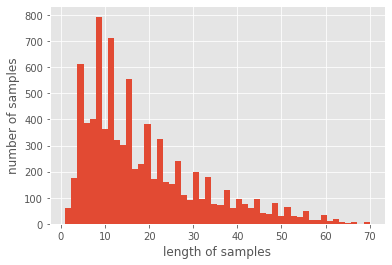

In [ ]:
total_vec = vec_train+vec_val
print('comments의 최대 길이 :',max(len(l) for l in total_vec))
print('comments의 평균 길이 :',sum(map(len, total_vec))/len(total_vec))
plt.hist([len(s) for s in total_vec], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def add_padding(vec_data, max_len):
    for sentence in vec_data:
        for i in range(len(sentence), max_len + 1):
            sentence.append(0)
    
    return np.array(vec_data)

x_train = add_padding(vec_train, 70)
x_val = add_padding(vec_val, 70)
y_train = df_train['label'].values
y_val = df_valid['label'].values

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(7896, 71)
(471, 71)
(7896,)
(471,)


# CNN modeling with Konlpy

In [ ]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla P100-PCIE-16GB


In [ ]:
def data_loader(train_inputs, val_inputs, train_labels, val_labels,
                batch_size=50):
    """Convert train and validation sets to torch.Tensors and load them to
    DataLoader.
    """

    # Convert data type to torch.Tensor
    train_inputs, val_inputs, train_labels, val_labels =\
    tuple(torch.tensor(data) for data in
          [train_inputs, val_inputs, train_labels, val_labels])

    # Specify batch_size
    batch_size = 50

    # Create DataLoader for training data
    train_data = TensorDataset(train_inputs, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Create DataLoader for validation data
    val_data = TensorDataset(val_inputs, val_labels)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

    return train_dataloader, val_dataloader

# Load data to PyTorch DataLoader
train_dataloader, val_dataloader = data_loader(x_train, x_val, y_train, y_val, batch_size=50)

In [ ]:
class CNN_NLP(nn.Module):
    """An 1D Convulational Neural Network for Sentence Classification."""
    def __init__(self,
                 pretrained_embedding=None,
                 freeze_embedding=False,
                 vocab_size=None,
                 embed_dim=300,
                 filter_sizes=[3, 4, 5],
                 num_filters=[100, 100, 100],
                 num_classes=2,
                 dropout=0.5):
        """
        The constructor for CNN_NLP class.

        Args:
            pretrained_embedding (torch.Tensor): Pretrained embeddings with
                shape (vocab_size, embed_dim)
            freeze_embedding (bool): Set to False to fine-tune pretraiend
                vectors. Default: False
            vocab_size (int): Need to be specified when not pretrained word
                embeddings are not used.
            embed_dim (int): Dimension of word vectors. Need to be specified
                when pretrained word embeddings are not used. Default: 300
            filter_sizes (List[int]): List of filter sizes. Default: [3, 4, 5]
            num_filters (List[int]): List of number of filters, has the same
                length as `filter_sizes`. Default: [100, 100, 100]
            n_classes (int): Number of classes. Default: 2
            dropout (float): Dropout rate. Default: 0.5
        """

        super(CNN_NLP, self).__init__()
        # Embedding layer
        if pretrained_embedding is not None:
            self.vocab_size, self.embed_dim = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
        else:
            self.embed_dim = embed_dim
            self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                          embedding_dim=self.embed_dim,
                                          padding_idx=0,
                                          max_norm=5.0)
        # Conv Network
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=self.embed_dim,
                      out_channels=num_filters[i],
                      kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))
        ])
        # Fully-connected layer and Dropout
        self.fc = nn.Linear(np.sum(num_filters), num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input_ids):
        """Perform a forward pass through the network.

        Args:
            input_ids (torch.Tensor): A tensor of token ids with shape
                (batch_size, max_sent_length)

        Returns:
            logits (torch.Tensor): Output logits with shape (batch_size,
                n_classes)
        """

        # Get embeddings from `input_ids`. Output shape: (b, max_len, embed_dim)
        x_embed = self.embedding(input_ids).float()

        # Permute `x_embed` to match input shape requirement of `nn.Conv1d`.
        # Output shape: (b, embed_dim, max_len)
        x_reshaped = x_embed.permute(0, 2, 1)

        # Apply CNN and ReLU. Output shape: (b, num_filters[i], L_out)
        x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]

        # Max pooling. Output shape: (b, num_filters[i], 1)
        x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2])
            for x_conv in x_conv_list]
        
        # Concatenate x_pool_list to feed the fully connected layer.
        # Output shape: (b, sum(num_filters))
        x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list],
                         dim=1)
        
        # Compute logits. Output shape: (b, n_classes)
        logits = self.fc(self.dropout(x_fc))

        return logits

In [ ]:
def initilize_model(pretrained_embedding=None,
                    freeze_embedding=False,
                    vocab_size=None,
                    embed_dim=300,
                    filter_sizes=[3, 4, 5],
                    num_filters=[100, 100, 100],
                    num_classes=2,
                    dropout=0.5,
                    learning_rate=0.01):
    """Instantiate a CNN model and an optimizer."""

    assert (len(filter_sizes) == len(num_filters)), "filter_sizes and \
    num_filters need to be of the same length."

    # Instantiate CNN model
    cnn_model = CNN_NLP(pretrained_embedding=pretrained_embedding,
                        freeze_embedding=freeze_embedding,
                        vocab_size=vocab_size,
                        embed_dim=embed_dim,
                        filter_sizes=filter_sizes,
                        num_filters=num_filters,
                        num_classes=3,
                        dropout=0.5)
    
    # Send model to `device` (GPU/CPU)
    cnn_model.to(device)

    # Instantiate Adadelta optimizer
    optimizer = optim.Adadelta(cnn_model.parameters(),
                               lr=learning_rate,
                               rho=0.95)

    return cnn_model, optimizer

In [ ]:
# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility."""

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, optimizer, train_dataloader, val_dataloader=None, epochs=10):
    """Train the CNN model."""
    
    # Tracking best validation accuracy
    best_accuracy = 0
    running_f = 0 
    # Start training loop
    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {\
    'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*60)

    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================

        # Tracking time and loss
        t0_epoch = time.time()
        total_loss = 0

        # Put the model into the training mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            # Load batch to GPU
            b_input_ids, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Update parameters
            optimizer.step()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        # =======================================
        #               Evaluation
        # =======================================
        if val_dataloader is not None:
            # After the completion of each training epoch, measure the model's
            # performance on our validation set.
            val_loss, val_accuracy, f1= evaluate(model, val_dataloader)

            # Track the best accuracy
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {avg_train_loss:^12.6f} | {\
            val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            
    print("\n")
    print(f"Training complete! Best accuracy and : {best_accuracy:.2f}% Best F1 Score : {f1:.2f}%")

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's
    performance on our validation set.
    """

    # Put the model into the evaluation mode. The dropout layers are disabled
    # during the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []
    f1 = 0
    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

        # Calculate F1 Score
        f1 += f1_score(b_labels.cpu().numpy(), preds.cpu().numpy(), average='macro')
    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)
    f1 = (f1/len(val_dataloader))*100
    return val_loss, val_accuracy, f1

In [ ]:
# CNN-rand: Word vectors are randomly initialized.
set_seed(1)
cnn_rand, optimizer = initilize_model(pretrained_embedding=None,
                                      freeze_embedding=False,
                                      vocab_size=kor_dict_size,
                                      embed_dim=300,
                                      learning_rate=0.25,
                                      dropout=0.5)
train(cnn_rand, optimizer, train_dataloader, val_dataloader, epochs=50)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   1.057150   |  1.030592  |   42.13   |   1.11   
   2    |   0.953412   |  0.958134  |   51.47   |   1.11   
   3    |   0.861053   |  0.933395  |   54.31   |   1.10   
   4    |   0.769440   |  0.932891  |   52.76   |   1.10   
   5    |   0.670264   |  0.905338  |   57.36   |   1.10   
   6    |   0.583951   |  0.899067  |   57.64   |   1.11   
   7    |   0.493017   |  0.927452  |   56.29   |   1.10   
   8    |   0.409943   |  0.930054  |   57.96   |   1.11   
   9    |   0.350348   |  0.934438  |   56.44   |   1.10   
  10    |   0.290596   |  0.936235  |   58.36   |   1.10   
  11    |   0.247631   |  1.010944  |   56.09   |   1.11   
  12    |   0.204976   |  1.041780  |   55.56   |   1.10   
  13    |   0.181652   |  1.071065  |   55.56   |   1.10   
  14    |   0.151244   |  1.061882  |   54.69   |   1.10   
  15    |   0.128692

In [ ]:
set_seed(1)
cnn_non_static, optimizer = initilize_model(pretrained_embedding=embedding_matrix_word2vec,
                                        freeze_embedding=False,
                                        learning_rate=0.25,
                                        dropout=0.5)
train(cnn_non_static, optimizer, train_dataloader, val_dataloader, epochs=50)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   1.092197   |  1.034936  |   43.21   |   1.08   
   2    |   0.941405   |  0.978001  |   47.21   |   1.08   
   3    |   0.876217   |  0.921278  |   49.29   |   1.08   
   4    |   0.821132   |  1.005073  |   46.69   |   1.08   
   5    |   0.770746   |  0.911755  |   53.76   |   1.08   
   6    |   0.716028   |  1.018768  |   48.96   |   1.08   
   7    |   0.676137   |  0.977159  |   52.91   |   1.09   
   8    |   0.632919   |  0.986585  |   50.76   |   1.07   
   9    |   0.590376   |  1.053000  |   49.01   |   1.08   
  10    |   0.531578   |  1.051042  |   50.49   |   1.08   
  11    |   0.507486   |  1.068999  |   51.16   |   1.09   
  12    |   0.469885   |  1.035655  |   52.96   |   1.08   
  13    |   0.443651   |  1.061095  |   53.56   |   1.08   
  14    |   0.412736   |  1.079099  |   53.84   |   1.07   
  15    |   0.378746

In [ ]:
set_seed(1)
cnn_non_static, optimizer = initilize_model(pretrained_embedding=embedding_matrix_glove,
                                            freeze_embedding=False,
                                            learning_rate=0.25,
                                            dropout=0.5)
train(cnn_non_static, optimizer, train_dataloader, val_dataloader, epochs=50)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   1.019248   |  0.942292  |   50.79   |   0.94   
   2    |   0.911987   |  0.910402  |   49.89   |   0.94   
   3    |   0.859230   |  0.939718  |   50.24   |   0.95   
   4    |   0.822140   |  0.878577  |   55.07   |   0.95   
   5    |   0.782147   |  0.855745  |   56.19   |   0.96   
   6    |   0.746065   |  0.872928  |   53.27   |   0.96   
   7    |   0.706587   |  0.871716  |   54.31   |   0.96   
   8    |   0.659635   |  0.869766  |   57.87   |   0.95   
   9    |   0.616181   |  0.859620  |   59.34   |   0.95   
  10    |   0.575923   |  0.930698  |   52.24   |   0.94   
  11    |   0.535182   |  0.949770  |   52.71   |   0.95   
  12    |   0.493185   |  0.951243  |   54.79   |   0.95   
  13    |   0.457449   |  0.963868  |   54.11   |   0.95   
  14    |   0.424762   |  0.953798  |   56.79   |   0.95   
  15    |   0.391868

In [ ]:
set_seed(1)
cnn_non_static, optimizer = initilize_model(pretrained_embedding=embedding_matrix_fasttext,
                                            freeze_embedding=False,
                                            learning_rate=0.25,
                                            dropout=0.5)
train(cnn_non_static, optimizer, train_dataloader, val_dataloader, epochs=50)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   1.111748   |  1.099193  |   34.96   |   1.28   
   2    |   1.077000   |  1.117504  |   34.49   |   1.27   
   3    |   1.069962   |  1.114567  |   34.49   |   1.28   
   4    |   1.064957   |  1.087951  |   39.96   |   1.27   
   5    |   1.059107   |  1.100502  |   34.89   |   1.27   
   6    |   1.046812   |  1.090270  |   39.96   |   1.27   
   7    |   1.040861   |  1.069954  |   39.09   |   1.27   
   8    |   1.033785   |  1.115446  |   36.09   |   1.27   
   9    |   1.028865   |  1.041543  |   43.56   |   1.28   
  10    |   1.024441   |  1.062449  |   39.36   |   1.28   
  11    |   1.019887   |  1.029285  |   44.64   |   1.28   
  12    |   1.015574   |  1.029469  |   45.16   |   1.27   
  13    |   1.004179   |  1.036358  |   42.64   |   1.28   
  14    |   0.996839   |  1.019503  |   45.76   |   1.28   
  15    |   0.985955

In [ ]:
def predict(text, model=cnn_non_static.to("cpu"), max_len=71):
    """Predict probability that a review is positive."""

    # Tokenize, pad and encode text
    text = vectorize_data(text, kor_dict)
    text = add_padding(text, 70)[0]

    # Convert to PyTorch tensors
    input_id = torch.tensor(text.tolist()).unsqueeze(dim=0)

    # Compute logits
    logits = model.forward(input_id)

    #  Compute probability
    probs = F.softmax(logits, dim=1).squeeze(dim=0)

    if probs[0] == max(probs) :
      print(f'Normal {max(probs)*100:.2f}%')
    elif probs[1] == max(probs) :
      print(f'Offensive {max(probs)*100:.2f}%')
    else : 
      print(f'Hate {max(probs)*100:.2f}%')

In [ ]:
for sentence in df_test['comments'].sample(20) :
  print(sentence)
  predict(sentence)
  print()

근데 본인이 아니라면 일단 아닌 걸로 인정해줘야 하는 거 아녀 그리고 이건 공소시효 남아있는 사건이니 바로 수사들어가야 될 듯 근데 바로 글 지운 것으로 봐서는 조민기 말이 맞을 확률이 높을 듯
Normal 53.14%

뭔가 탈세밖에 생각나지않는 이미지가 되버림
Normal 53.15%

뭐하는 듣보잡임 
Normal 53.08%

30년이면 5공때잖아 ㅋㅋㅋㅋㅋ 자 이제 일제강점기랑 조선시대 미투도 가자
Normal 53.16%

아 시발 더러워 ㅡㅡㅋ 제발 늙은것들은 젊은 사람 탐하지마라 남녀 모두 ㅡㅡ 진짜 더러워
Normal 53.23%

한혜진 티비보먼서 좃니 빡치겟다 ㅋㅋㅋㅋ
Normal 53.07%

기혼자고 뚱하면 다 아줌마라는거네 미혼인데 뚱하고 아줌마소리 들으면 속상하거따
Normal 53.05%

구하라 차피 B급연예인인데 맞아도 뭐ㅋㅋㅋㅋㅋ아무도 안슬퍼하고 남자가 오죽했으면 때리겠냐ㅋㅋ난 이해함
Normal 53.23%

마음이 깊고 예쁜 송혜교 절대 울지말고 지금부턴 활짝웃자
Normal 53.20%

팀 이름 느와르 말고 너구리는 어떠냐 
Normal 53.12%

윤아는 톱클라스중에 톱인데 허이구 여신님 죽기전에 함껴안아보자 ㅠㅠ
Normal 53.08%

3세대 아이돌들의 몰락
Normal 53.16%

솔직히 이상하다
Normal 53.07%

윤하 못하는건 밤일
Normal 53.08%

OOO들이박나래대상예언하지 ㅋ누가봐도이영자대상이맞지정따지고싶음 스브스가서이승기대상왜줬는지물어봐라 ㅋ
Normal 52.92%

니들이 뭔데 김미화가 sns 글을 적든말든 뭔 상관 
Normal 53.17%

우한 화이팅 중국 화이팅 한국연예인도 화이팅 한국은 연예인 자살율 1위라는데 못잡아먹어서 안달난 국민성때문에 ㅉㅉ
Normal 53.13%

나이트밤무대같은 의상입고 사람들앞에서 춤추는 아내가 뭐가 그리 자랑스러울까ㅠ
Normal 53.17%

백지영이 너무 아깝고 안타깝고 안쓰럽네
Normal 53.18%

우울증 이상증세같다 저러다 자

# CNN with Wordpiece Toeknizer 

In [ ]:
def vectorize_data_fast(data):
    vec_sentence = []

    for sentence in data:
      vec_sentence.append(fast_tokenizer.encode(sentence))
      
    return vec_sentence

vec_train_fast = vectorize_data_fast(df_train['comments'])
vec_val_fast = vectorize_data_fast(df_valid['comments'])

comments의 최대 길이 : 77
comments의 평균 길이 : 21.457272618620774


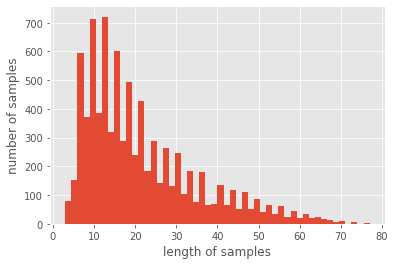

In [ ]:
total_vec_fast = vec_train_fast+vec_val_fast
print('comments의 최대 길이 :',max(len(l) for l in total_vec_fast))
print('comments의 평균 길이 :',sum(map(len, total_vec_fast))/len(total_vec_fast))
plt.hist([len(s) for s in total_vec_fast], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def add_padding_fast(vec_data, max_len):
    for sentence in vec_data:
        for i in range(len(sentence), max_len + 1):
            sentence.append(0)
    
    return np.array(vec_data)

x_train_fast = add_padding_fast(vec_train_fast, 77)
x_val_fast = add_padding_fast(vec_val_fast, 77)
y_train_fast = df_train['label'].values
y_val_fast = df_valid['label'].values

print(x_train_fast.shape)
print(x_val_fast.shape)
print(y_train_fast.shape)
print(y_val_fast.shape)

(7896, 78)
(471, 78)
(7896,)
(471,)


In [ ]:
def data_loader(train_inputs, val_inputs, train_labels, val_labels,
                batch_size=50):
    """Convert train and validation sets to torch.Tensors and load them to
    DataLoader.
    """

    # Convert data type to torch.Tensor
    train_inputs, val_inputs, train_labels, val_labels =\
    tuple(torch.tensor(data) for data in
          [train_inputs, val_inputs, train_labels, val_labels])

    # Specify batch_size
    batch_size = 50

    # Create DataLoader for training data
    train_data = TensorDataset(train_inputs, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Create DataLoader for validation data
    val_data = TensorDataset(val_inputs, val_labels)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

    return train_dataloader, val_dataloader

# Load data to PyTorch DataLoader
train_dataloader_fast, val_dataloader_fast = data_loader(x_train_fast, x_val_fast, y_train_fast, y_val_fast, batch_size=50)

In [ ]:
class CNN_NLP(nn.Module):
    """An 1D Convulational Neural Network for Sentence Classification."""
    def __init__(self,
                 pretrained_embedding=None,
                 freeze_embedding=False,
                 vocab_size=None,
                 embed_dim=300,
                 filter_sizes=[3, 4, 5],
                 num_filters=[100, 100, 100],
                 num_classes=2,
                 dropout=0.5):
        """
        The constructor for CNN_NLP class.

        Args:
            pretrained_embedding (torch.Tensor): Pretrained embeddings with
                shape (vocab_size, embed_dim)
            freeze_embedding (bool): Set to False to fine-tune pretraiend
                vectors. Default: False
            vocab_size (int): Need to be specified when not pretrained word
                embeddings are not used.
            embed_dim (int): Dimension of word vectors. Need to be specified
                when pretrained word embeddings are not used. Default: 300
            filter_sizes (List[int]): List of filter sizes. Default: [3, 4, 5]
            num_filters (List[int]): List of number of filters, has the same
                length as `filter_sizes`. Default: [100, 100, 100]
            n_classes (int): Number of classes. Default: 2
            dropout (float): Dropout rate. Default: 0.5
        """

        super(CNN_NLP, self).__init__()
        # Embedding layer
        if pretrained_embedding is not None:
            self.vocab_size, self.embed_dim = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
        else:
            self.embed_dim = embed_dim
            self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                          embedding_dim=self.embed_dim,
                                          padding_idx=0,
                                          max_norm=5.0)
        # Conv Network
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=self.embed_dim,
                      out_channels=num_filters[i],
                      kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))
        ])
        # Fully-connected layer and Dropout
        self.fc = nn.Linear(np.sum(num_filters), num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input_ids):
        """Perform a forward pass through the network.

        Args:
            input_ids (torch.Tensor): A tensor of token ids with shape
                (batch_size, max_sent_length)

        Returns:
            logits (torch.Tensor): Output logits with shape (batch_size,
                n_classes)
        """

        # Get embeddings from `input_ids`. Output shape: (b, max_len, embed_dim)
        x_embed = self.embedding(input_ids).float()

        # Permute `x_embed` to match input shape requirement of `nn.Conv1d`.
        # Output shape: (b, embed_dim, max_len)
        x_reshaped = x_embed.permute(0, 2, 1)

        # Apply CNN and ReLU. Output shape: (b, num_filters[i], L_out)
        x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]

        # Max pooling. Output shape: (b, num_filters[i], 1)
        x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2])
            for x_conv in x_conv_list]
        
        # Concatenate x_pool_list to feed the fully connected layer.
        # Output shape: (b, sum(num_filters))
        x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list],
                         dim=1)
        
        # Compute logits. Output shape: (b, n_classes)
        logits = self.fc(self.dropout(x_fc))

        return logits

In [ ]:
def initilize_model(pretrained_embedding=None,
                    freeze_embedding=False,
                    vocab_size=None,
                    embed_dim=300,
                    filter_sizes=[3, 4, 5],
                    num_filters=[100, 100, 100],
                    num_classes=2,
                    dropout=0.5,
                    learning_rate=0.01):
    """Instantiate a CNN model and an optimizer."""

    assert (len(filter_sizes) == len(num_filters)), "filter_sizes and \
    num_filters need to be of the same length."

    # Instantiate CNN model
    cnn_model = CNN_NLP(pretrained_embedding=pretrained_embedding,
                        freeze_embedding=freeze_embedding,
                        vocab_size=vocab_size,
                        embed_dim=embed_dim,
                        filter_sizes=filter_sizes,
                        num_filters=num_filters,
                        num_classes=3,
                        dropout=0.5)
    
    # Send model to `device` (GPU/CPU)
    cnn_model.to(device)

    # Instantiate Adadelta optimizer
    optimizer = optim.Adadelta(cnn_model.parameters(),
                               lr=learning_rate,
                               rho=0.95)

    return cnn_model, optimizer

In [ ]:
# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility."""

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, optimizer, train_dataloader, val_dataloader=None, epochs=10):
    """Train the CNN model."""
    
    # Tracking best validation accuracy
    best_accuracy = 0
    running_f = 0 
    # Start training loop
    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {\
    'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*60)

    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================

        # Tracking time and loss
        t0_epoch = time.time()
        total_loss = 0

        # Put the model into the training mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            # Load batch to GPU
            b_input_ids, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Update parameters
            optimizer.step()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        # =======================================
        #               Evaluation
        # =======================================
        if val_dataloader is not None:
            # After the completion of each training epoch, measure the model's
            # performance on our validation set.
            val_loss, val_accuracy, f1= evaluate(model, val_dataloader)

            # Track the best accuracy
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {avg_train_loss:^12.6f} | {\
            val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            
    print("\n")
    print(f"Training complete! Best accuracy and : {best_accuracy:.2f}% Best F1 Score : {f1:.2f}%")

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's
    performance on our validation set.
    """

    # Put the model into the evaluation mode. The dropout layers are disabled
    # during the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []
    f1 = 0
    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

        # Calculate F1 Score
        f1 += f1_score(b_labels.cpu().numpy(), preds.cpu().numpy(), average='macro')
    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)
    f1 = (f1/len(val_dataloader))*100
    return val_loss, val_accuracy, f1

In [ ]:
# CNN-rand: Word vectors are randomly initialized.
set_seed(1)
cnn_rand, optimizer = initilize_model(vocab_size=fast_tokenizer.vocab_size,
                                      embed_dim=200,
                                      learning_rate=0.25,
                                      dropout=0.5)
train(cnn_rand, optimizer, train_dataloader_fast, val_dataloader_fast, epochs=50)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   1.064730   |  1.031781  |   40.09   |   1.20   
   2    |   0.973267   |  0.983765  |   48.71   |   1.18   
   3    |   0.890682   |  0.983929  |   46.36   |   1.18   
   4    |   0.808695   |  0.949972  |   51.96   |   1.19   
   5    |   0.739290   |  0.923009  |   52.11   |   1.18   
   6    |   0.662076   |  0.956140  |   55.11   |   1.18   
   7    |   0.589530   |  0.959229  |   53.04   |   1.18   
   8    |   0.521582   |  0.971731  |   53.71   |   1.18   
   9    |   0.460021   |  0.953957  |   53.64   |   1.18   
  10    |   0.393834   |  0.930821  |   57.71   |   1.18   
  11    |   0.350043   |  1.026630  |   52.64   |   1.18   
  12    |   0.308727   |  0.992347  |   56.59   |   1.18   
  13    |   0.275040   |  1.011925  |   55.27   |   1.19   
  14    |   0.236851   |  0.998761  |   56.87   |   1.18   
  15    |   0.210233

In [ ]:
embedding_matrix = np.random.uniform(-0.25, 0.25, (len(fast_tokenizer.vocab), ko_fasttext.vector_size))
embedding_matrix[0] = np.zeros((ko_fasttext.vector_size,))

def get_vector(word, embedding_model):
    if word in embedding_model:
        return embedding_model[word]
    else:
        return None

def get_embedding_matrix(vocab, embedding_model, matrix):
  for word, i in vocab.vocab.items(): 
      temp = get_vector(word, embedding_model)
      if temp is not None:
          matrix[i] = np.array(temp, dtype=np.float32)
  return matrix
  
embedding_matrix_fasttext_fast = get_embedding_matrix(fast_tokenizer, ko_fasttext, embedding_matrix)
embedding_matrix_fasttext_fast = torch.tensor(embedding_matrix_fasttext_fast)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [ ]:
# CNN-static: fastText pretrained word vectors are used and freezed during training.
set_seed(1)
cnn_static, optimizer = initilize_model(pretrained_embedding=embedding_matrix_fasttext_fast,
                                        freeze_embedding=True,
                                        learning_rate=0.25,
                                        dropout=0.5)
train(cnn_static, optimizer, train_dataloader_fast, val_dataloader_fast, epochs=50)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   1.098044   |  1.099572  |   40.61   |   0.83   
   2    |   1.081273   |  1.190163  |   34.49   |   0.82   
   3    |   1.060619   |  1.136864  |   34.49   |   0.82   
   4    |   1.057215   |  1.092014  |   39.89   |   0.82   
   5    |   1.054794   |  1.090449  |   35.09   |   0.82   
   6    |   1.045971   |  1.096377  |   40.44   |   0.82   
   7    |   1.037002   |  1.054594  |   40.84   |   0.82   
   8    |   1.020138   |  1.140045  |   35.69   |   0.82   
   9    |   1.018061   |  1.017331  |   49.96   |   0.82   
  10    |   1.006792   |  1.075463  |   45.91   |   0.82   
  11    |   1.002553   |  1.040493  |   48.44   |   0.83   
  12    |   1.005107   |  1.042975  |   50.56   |   0.82   
  13    |   0.984562   |  1.040848  |   46.79   |   0.82   
  14    |   0.977633   |  1.066122  |   48.56   |   0.82   
  15    |   0.979820

In [ ]:
# CNN-non-static: fastText pretrained word vectors are fine-tuned during training.
set_seed(1)
cnn_non_static, optimizer = initilize_model(pretrained_embedding=embedding_matrix_fasttext_fast,
                                            freeze_embedding=False,
                                            learning_rate=0.25,
                                            dropout=0.5)
train(cnn_non_static, optimizer, train_dataloader_fast, val_dataloader_fast, epochs=50)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   1.098132   |  1.101493  |   39.96   |   1.78   
   2    |   1.081440   |  1.181139  |   34.49   |   1.76   
   3    |   1.058887   |  1.135820  |   34.49   |   1.76   
   4    |   1.049712   |  1.079649  |   41.09   |   1.77   
   5    |   1.043673   |  1.114455  |   36.49   |   1.76   
   6    |   1.033237   |  1.079636  |   43.64   |   1.76   
   7    |   1.019020   |  1.052653  |   41.84   |   1.77   
   8    |   0.997291   |  1.138294  |   38.09   |   1.77   
   9    |   0.990949   |  0.993172  |   51.84   |   1.76   
  10    |   0.977883   |  1.029618  |   48.59   |   1.76   
  11    |   0.969246   |  1.005577  |   52.04   |   1.76   
  12    |   0.964017   |  0.989611  |   52.91   |   1.76   
  13    |   0.936307   |  0.975257  |   49.67   |   1.76   
  14    |   0.931991   |  1.004226  |   49.99   |   1.76   
  15    |   0.919955

In [ ]:
embedding_matrix = np.random.uniform(-0.25, 0.25, (len(fast_tokenizer.vocab), 100))
embedding_matrix[0] = np.zeros((100,))

def get_vector(word, embedding_model):
    if word in embedding_model:
        return embedding_model[word]
    else:
        return None

def get_embedding_matrix(vocab, embedding_model, matrix):
  for word, i in vocab.vocab.items(): 
      temp = get_vector(word, embedding_model)
      if temp is not None:
          matrix[i] = np.array(temp, dtype=np.float32)
  return matrix
  
embedding_matrix_glove_fast = get_embedding_matrix(fast_tokenizer, embedding_dict, embedding_matrix)
embedding_matrix_glove_fast = torch.tensor(embedding_matrix_glove_fast)

In [ ]:
set_seed(1)
cnn_non_static, optimizer = initilize_model(pretrained_embedding=embedding_matrix_glove_fast,
                                            freeze_embedding=True,
                                            learning_rate=0.25,
                                            dropout=0.5)
train(cnn_non_static, optimizer, train_dataloader_fast, val_dataloader_fast, epochs=50)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   1.046457   |  1.010945  |   49.31   |   0.74   
   2    |   0.962528   |  0.988263  |   47.04   |   0.73   
   3    |   0.907876   |  1.013378  |   45.24   |   0.73   
   4    |   0.871993   |  0.940204  |   51.04   |   0.73   
   5    |   0.832055   |  0.912178  |   53.59   |   0.73   
   6    |   0.795601   |  0.904347  |   54.27   |   0.73   
   7    |   0.756857   |  0.944751  |   50.79   |   0.73   
   8    |   0.714828   |  0.897710  |   53.19   |   0.72   
   9    |   0.667974   |  0.885065  |   55.07   |   0.72   
  10    |   0.630640   |  0.923189  |   52.39   |   0.73   
  11    |   0.592509   |  0.929122  |   53.34   |   0.73   
  12    |   0.553454   |  0.922777  |   55.14   |   0.73   
  13    |   0.516652   |  0.939198  |   54.59   |   0.73   
  14    |   0.488858   |  0.924358  |   56.07   |   0.73   
  15    |   0.463793

In [ ]:
set_seed(1)
cnn_non_static, optimizer = initilize_model(pretrained_embedding=embedding_matrix_glove_fast,
                                            freeze_embedding=False,
                                            learning_rate=0.25,
                                            dropout=0.5)
train(cnn_non_static, optimizer, train_dataloader_fast, val_dataloader_fast, epochs=50)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   1.045754   |  1.010561  |   49.31   |   1.11   
   2    |   0.959401   |  0.983505  |   46.96   |   1.11   
   3    |   0.901505   |  1.003371  |   45.44   |   1.11   
   4    |   0.860971   |  0.930410  |   50.24   |   1.10   
   5    |   0.815675   |  0.904139  |   53.79   |   1.10   
   6    |   0.775806   |  0.895146  |   54.27   |   1.11   
   7    |   0.731660   |  0.935929  |   49.51   |   1.10   
   8    |   0.686116   |  0.885183  |   52.71   |   1.11   
   9    |   0.633071   |  0.880783  |   54.47   |   1.11   
  10    |   0.594677   |  0.924455  |   52.39   |   1.11   
  11    |   0.551198   |  0.932371  |   53.94   |   1.11   
  12    |   0.506111   |  0.930246  |   54.67   |   1.10   
  13    |   0.466181   |  0.965622  |   53.79   |   1.10   
  14    |   0.433044   |  0.931165  |   55.14   |   1.11   
  15    |   0.410202

In [ ]:
def predict(text, model=cnn_non_static.to("cpu"), max_len=78):
    """Predict probability that a review is positive."""

    # Tokenize, pad and encode text
    text = vectorize_data_fast(text)
    text = add_padding_fast(text, 75)[0]

    # Convert to PyTorch tensors
    input_id = torch.tensor(text.tolist()).unsqueeze(dim=0)

    # Compute logits
    logits = model.forward(input_id)

    #  Compute probability
    probs = F.softmax(logits, dim=1).squeeze(dim=0)

    if probs[0] == max(probs) :
      print(f'Normal {max(probs)*100:.2f}%')
    elif probs[1] == max(probs) :
      print(f'Offensive {max(probs)*100:.2f}%')
    else : 
      print(f'Hate {max(probs)*100:.2f}%')

In [ ]:
for sentence in df_test['comments'].sample(20) :
  print(sentence)
  predict(sentence)
  print()

응원하는게 나쁜거냐 우리가 이런 상황이라면 사람들이 우리외면 좋겟냐 생각들 좀하고 댓글 달아라
Offensive 75.19%

벗방으로 가시려나 ㅡㅡ
Hate 63.87%

이것도 막장
Normal 51.21%

누군데 얘네 
Offensive 61.10%

근데 토지배우랑 친정엄마랑1박2일 배우분들은 조문 안하시나요
Normal 89.93%

당분간 나하고 잠자리를 못하갯군 아쉽다 수지로 갈아타야지
Offensive 58.53%

누구를 덥으려고하는지 모르지만 죄값은 받아야지 버닝썬은 덥어지는건가 
Offensive 61.10%

내가 20대부터 지금 50대 중반인 지금까지 주말드라마는 kbs2만 봤다 재미없어도 그냥 봤다 그런데 지금 드라마가 최고 재미없고 가장 가족적이지 않은 드라마다 물론 마지막은 해피엔딩이겠지만 그래도 본다ㅠㅋㅠ
Normal 49.21%

다이어트는 긁지않은 복권
Offensive 41.82%

혜영언니 더위에 고생이셔
Normal 76.44%

이쁜이 내 첫사랑 누나 나랑 꼭 결혼하자 용인 30살 송호기가 
Normal 51.21%

조심하세요 우리나라 사람들는 누가 잘나간다 싶으면 뭐든지 잡아서 물어뜯을려고 하거든요
Offensive 56.35%

사진 굉장히 인상적이고 특이하네요 
Normal 45.99%

그래도 한번쯤 운명을 되돌려 보고 싶은 맘
Offensive 63.93%

방송기간은 좀 남았는데 이렇게 빨리 밝혀지고 얼마나 질질끌지 예상되네 여튼 도란이가족 행복하게 해주세요 
Offensive 44.83%

와 부럽다 한채아정도면 객관적으로 절세미인인데 얼굴도 이쁘고 몸매도 좋고 
Normal 56.37%

ㅎㅎ 로봇이 아니야와 비슷한 양상인듯 
Offensive 75.51%

걍 제발 연예인들 보고 즐기고 예능으로 보라범죄 저지른것 아니면 배놔라 감놔라 악플달지말고ᆢ너희 가족은 완벽하냐 하여간 울 나라 섹히들 남말은 잘도해 자기 앞가림도 못하면서 ᆢ
Offensive 41.12%

근데 서예지랑 김수현 사귀는거같당 쁘띠

# Pre-trained embedding

In [ ]:
# word2vec

ko_word2vec = Word2Vec.load('./drive/My Drive/torch_project/hate_speech/embedding/bins/ko.bin')

In [ ]:
embedding_matrix = np.random.uniform(-0.25, 0.25, (kor_dict_size, ko_word2vec.vector_size))
embedding_matrix[0] = np.zeros((ko_word2vec.vector_size,))

def get_vector(word, embedding_model):
    if word in embedding_model:
        return embedding_model[word]
    else:
        return None

def get_embedding_matrix(vocab, embedding_model, matrix):
  for word, i in vocab.items(): 
      temp = get_vector(word, embedding_model)
      if temp is not None:
          matrix[i] = np.array(temp, dtype=np.float32)
  return matrix
  
embedding_matrix_word2vec = get_embedding_matrix(kor_dict, ko_word2vec, embedding_matrix)
embedding_matrix_word2vec = torch.tensor(embedding_matrix_word2vec)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [ ]:
# 확인 

print(kor_dict['경찰'])
print(ko_word2vec['경찰'])
print(embedding_matrix_word2vec[1106])

1106
[ 0.35018748  0.25260732 -1.6961552  -0.24070111  1.458881   -2.618083
 -0.88496584  0.80293846 -0.6349493  -2.1885054   0.6086541   0.2931475
 -0.16648364  0.41184306 -0.6008869  -0.36909053  0.90012896 -1.1467297
 -1.1128821   2.6762924  -0.10494678 -0.08629697  0.21400233  0.38342196
 -1.4224446  -1.992894    0.1214328   1.2755431  -0.9847605   0.8754856
  1.0342635  -1.379144   -0.80806506 -0.07673324  0.02347215 -2.1491754
  1.7213204   0.33681965 -0.54187816 -0.22070144 -1.1077498   0.04403979
 -0.8344712   0.48663393 -0.44776055  0.9900449   2.7058744   1.8463963
  0.6769699  -0.36655942 -1.2137656   1.3017988  -0.12040459 -0.20948486
  0.7907194  -0.07913183  3.7588146   1.6482228   0.9398533  -1.9750487
  0.5171005  -1.3734077   0.6080996   0.3160369  -0.5086737  -0.92624223
 -0.10156266  0.30070072  1.0656439   0.24289903 -0.30307302 -2.2601168
  0.8705727   0.52337444  0.00804046  1.4466366   1.1721483   0.26486674
  0.3180528  -1.1703359  -0.5999147   0.5136074   2.333

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [ ]:
# fasttext

ko_fasttext = FastText.load_fasttext_format('./drive/My Drive/torch_project/hate_speech/embedding/bins/wiki.ko.bin')

In [ ]:
ko_fasttext.most_similar('경찰')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('경찰물', 0.9707494378089905),
 ('경찰팀', 0.9614406228065491),
 ('경찰인', 0.9563154578208923),
 ('경찰관의', 0.95359206199646),
 ('경효', 0.9528306722640991),
 ('경찰용', 0.9513285160064697),
 ('경찰을', 0.9500089883804321),
 ('경해', 0.9495295286178589),
 ('경년', 0.9486699104309082),
 ('경치에', 0.9483065605163574)]

In [ ]:
embedding_matrix = np.random.uniform(-0.25, 0.25, (kor_dict_size, ko_fasttext.vector_size))
embedding_matrix[0] = np.zeros((ko_fasttext.vector_size,))

def get_vector(word, embedding_model):
    if word in embedding_model:
        return embedding_model[word]
    else:
        return None

def get_embedding_matrix(vocab, embedding_model, matrix):
  for word, i in vocab.items(): 
      temp = get_vector(word, embedding_model)
      if temp is not None:
          matrix[i] = np.array(temp, dtype=np.float32)
  return matrix
  
embedding_matrix_fasttext = get_embedding_matrix(kor_dict, ko_fasttext, embedding_matrix)
embedding_matrix_fasttext = torch.tensor(embedding_matrix_fasttext)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [ ]:
# glove

embedding_dict = dict()
f = open('./drive/My Drive/torch_project/hate_speech/embedding/glove/glove.txt', encoding="utf8")

for line in f:
    word_vector = line.split()
    word = word_vector[0]
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32') # 100개의 값을 가지는 array로 변환
    embedding_dict[word] = word_vector_arr
f.close()
print('%s개의 Embedding vector가 있습니다.' % len(embedding_dict))

358043개의 Embedding vector가 있습니다.


In [ ]:
print(embedding_dict['경찰'])
print(len(embedding_dict['경찰']))

[-1.098720e-01  8.643660e-01  2.021140e-01  3.460400e-02  1.168260e-01
 -2.679120e-01  2.571140e-01  1.798460e-01 -7.247020e-01  2.548440e-01
  1.364900e-02  6.110700e-02 -1.933860e-01 -1.045490e-01 -1.756260e-01
 -7.777000e-02  2.528210e-01  9.726810e-01  3.435570e-01 -2.342170e-01
  1.670587e+00 -1.380610e-01  5.433650e-01  1.691790e-01  6.285460e-01
  8.228800e-02 -4.472400e-02 -6.505720e-01  2.035410e-01  3.735740e-01
 -3.349360e-01  3.403360e-01 -4.228510e-01 -2.593590e-01 -2.746440e-01
 -1.129400e-01  2.741080e-01 -8.838710e-01 -6.353660e-01  5.597030e-01
 -7.150810e-01 -1.977010e-01  1.312240e-01  7.424040e-01 -1.157000e-03
  1.099102e+00 -4.496560e-01 -1.705710e-01  7.524770e-01 -5.293000e-03
  3.751000e-03 -4.866780e-01 -7.556600e-02 -6.043470e-01 -2.677000e-02
  4.427370e-01 -1.107074e+00  4.578340e-01 -1.545410e-01  5.740590e-01
 -1.119288e+00  9.323250e-01 -5.250960e-01 -3.126250e-01  8.713340e-01
  6.154700e-02  7.198100e-02 -1.659211e+00 -9.037870e-01 -6.982040e-01
 -1.25

In [ ]:
def find_closest_embeddings(embedding):
    return sorted(embedding_dict.keys(), key=lambda word: spatial.distance.euclidean(embedding_dict[word], embedding))

find_closest_embeddings(embedding_dict["아이언맨"])[:5]

['아이언맨', 'Infamous', '어벤져스', '테이큰', '스타크']

In [ ]:
glove_input_file = './drive/My Drive/torch_project/hate_speech/embedding/glove/glove.txt'
word2vec_output_file = './drive/My Drive/torch_project/hate_speech/embedding/glove/glove.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

# load the Stanford GloVe model
filename = word2vec_output_file
model = KeyedVectors.load_word2vec_format(filename, binary=False)
# calculate: (king - man) + woman = ?
result = model.most_similar(positive=['왕비', '왕'], negative=['남자'], topn=1)
print(result)

[('국왕', 0.6930677890777588)]


In [ ]:
embedding_matrix = np.random.uniform(-0.25, 0.25, (kor_dict_size, 100))
embedding_matrix[0] = np.zeros((100,))

def get_vector(word, embedding_model):
    if word in embedding_model:
        return embedding_model[word]
    else:
        return None

def get_embedding_matrix(vocab, embedding_model, matrix):
  for word, i in vocab.items(): 
      temp = get_vector(word, embedding_model)
      if temp is not None:
          matrix[i] = np.array(temp, dtype=np.float32)
  return matrix
  
embedding_matrix_glove = get_embedding_matrix(kor_dict, embedding_dict, embedding_matrix)
embedding_matrix_glove = torch.tensor(embedding_matrix_glove)